In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf
import networkx as nx
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.python.ops import gen_array_ops

In [2]:
# NUMBER_NODES = 9
NUMBER_NODES = 7
# NUMBER_NODES = 5
DATASET_PATH = f'../../../datasets/examples/opt_band_{NUMBER_NODES}_nodes_graph.csv'

def load_data():
    featuresNumber = (NUMBER_NODES * NUMBER_NODES - NUMBER_NODES) // 2 

    def get_tuple_dataset(row):
        X = row[0 : featuresNumber].astype('float32')
        Y = row[featuresNumber: ].astype('float32') # opt_band is in target
        return X, Y

    df = pd.read_csv(DATASET_PATH)
    train_dataset_df = df.sample(frac=0.8)
    df_remaining = df.drop(index=train_dataset_df.index)
    val_dataset_df = df_remaining.sample(frac=0.7)
    test_dataset_df = df_remaining.drop(index=val_dataset_df.index)

    train_dataset = list(map(get_tuple_dataset, train_dataset_df.to_numpy()))
    val_dataset = list(map(get_tuple_dataset, val_dataset_df.to_numpy()))
    test_dataset = list(map(get_tuple_dataset, test_dataset_df.to_numpy()))
    return train_dataset, val_dataset, test_dataset

In [3]:
train_dataset, val_dataset, test_dataset = load_data()

In [4]:
def getGraph(upperTriangleAdjMatrix):
    dense_adj = np.zeros((NUMBER_NODES, NUMBER_NODES))
    dense_adj = np.zeros((NUMBER_NODES, NUMBER_NODES))
    k = 0
    for i in range(NUMBER_NODES):
        for j in range(NUMBER_NODES):
            if i == j:
                continue
            elif i < j:
                dense_adj[i][j] = upperTriangleAdjMatrix[k]
                k += 1
            else:
                dense_adj[i][j] = dense_adj[j][i]
    return dense_adj

In [5]:
def processDataToImage(graphInput):
    graph_adj = getGraph(graphInput)
    plt.imshow(graph_adj, cmap="gray")
    plt.xticks([])
    plt.yticks([])
    plt.savefig(f'./Graph_adj_input_mse.png')
    plt.clf()
    image_input = tf.keras.preprocessing.image.load_img(f'./Graph_adj_input_mse.png')
    image_input_arr = tf.keras.preprocessing.image.img_to_array(image_input)
    image_input_np = np.array(image_input_arr)
    # image_input_np = image_input_np / 255.0

    image_input_np = tf.image.resize(image_input_np, [32, 32])
    return image_input_np


In [6]:
def getData(dataset):
    train_images = []
    train_nodelist = []
    train_bandwidth = []
    for graphInput, target in dataset:
        optband = target[0]
        graphNodeList = target[1 : ]
        x_image = processDataToImage(graphInput)
        train_images.append(x_image)
        train_nodelist.append(graphNodeList)
        train_bandwidth.append([optband])
    return np.array(train_images), (np.array(train_nodelist) / 10), np.array(train_bandwidth)

In [7]:
def getData_2(dataset):
    train_images = []
    train_nodelist = []
    for graphInput, target in dataset:
        graphNodeList = target[1 : ]
        x_image = processDataToImage(graphInput)
        train_images.append(x_image)
        train_nodelist.append(graphNodeList)
    # mlb = MultiLabelBinarizer()
    # labels = mlb.fit_transform(train_nodelist)
    return np.array(train_images), np.array(train_nodelist) / 10

In [8]:
# train_images, train_nodelist, train_bandwidth = getData(train_dataset)
# val_images, val_nodelist, val_bandwidth = getData(val_dataset)
# test_images, test_nodelist, test_bandwidth = getData(test_dataset)
# print(train_images.shape)
# print(train_nodelist.shape)
# print(train_bandwidth.shape)

In [9]:
train_images, train_nodelist = getData_2(train_dataset)
val_images, val_nodelist= getData_2(val_dataset)
test_images, test_nodelist = getData_2(test_dataset)

# aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
# 	height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
# 	horizontal_flip=True, fill_mode="nearest")

print(train_images.shape)
print(train_nodelist.shape)

(835, 32, 32, 3)
(835, 7)


<Figure size 432x288 with 0 Axes>

In [38]:
maeLoss = tf.keras.losses.MeanAbsoluteError()
loss_object = tf.keras.losses.MeanSquaredError()

def loss_repeated_labels(roundedOutput, true):
  true_used, true_indexes = tf.unique(tf.squeeze(true))
  used_labels, indexes, counts = tf.unique_with_counts(tf.squeeze(roundedOutput))
  counts = tf.cast(counts, tf.float32)
  # 1 - counts = quao longe os elementos de counts estão de repetir uma vez só (elemento unico)
  squaredDiff = loss_object(tf.ones_like(counts), counts)
  mseIndexes = loss_object(tf.cast(true_indexes, tf.float32), tf.cast(indexes, tf.float32))
  # o quao longe os indexes estao de ser 0,1,2,3,4,5,6
  loss = tf.math.reduce_variance(counts) + mseIndexes
  return loss

def customLoss(true, pred):
  mae = maeLoss(true, pred)
  roundedOutput = tf.round(pred)
  loss_repeated = loss_repeated_labels(roundedOutput, true)
  return mae + loss_repeated


In [39]:
data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(32, 32, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

model = tf.keras.models.Sequential([
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(NUMBER_NODES, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss=customLoss,
              metrics=['accuracy'])

history = model.fit(
    train_images, train_nodelist,
    validation_data=(val_images, val_nodelist),
    epochs=180,
    batch_size=1
)

Epoch 1/180
835/835 [==============================] - 6s 5ms/step - loss: 15.5009 - accuracy: 0.3437 - val_loss: 18.0554 - val_accuracy: 0.3082
Epoch 2/180
835/835 [==============================] - 4s 5ms/step - loss: 14.2294 - accuracy: 0.2898 - val_loss: 14.8074 - val_accuracy: 0.4315
Epoch 3/180
835/835 [==============================] - 4s 4ms/step - loss: 14.8014 - accuracy: 0.3749 - val_loss: 15.4034 - val_accuracy: 0.3699
Epoch 4/180
835/835 [==============================] - 4s 4ms/step - loss: 15.2627 - accuracy: 0.4287 - val_loss: 15.3145 - val_accuracy: 0.4178
Epoch 5/180
835/835 [==============================] - 4s 4ms/step - loss: 15.7224 - accuracy: 0.4778 - val_loss: 16.0317 - val_accuracy: 0.5274
Epoch 6/180
835/835 [==============================] - 4s 4ms/step - loss: 15.7826 - accuracy: 0.4826 - val_loss: 17.1349 - val_accuracy: 0.5205
Epoch 7/180
835/835 [==============================] - 4s 5ms/step - loss: 16.1387 - accuracy: 0.5018 - val_loss: 16.3493 - val_ac

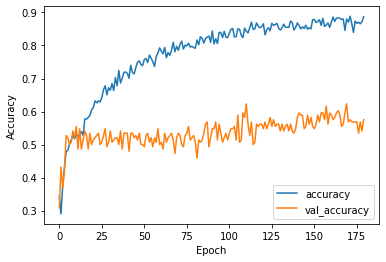

In [40]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

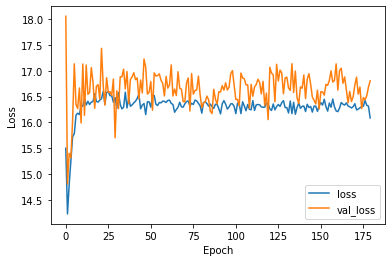

In [41]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

In [42]:
# test = np.array([test_images[0]])
pred = model.predict(test_images)
true = test_nodelist
# print(pred)
print("Pred")
print((pred * 10).round())
print("True")
print(true*10)

Pred
[[2. 3. 6. 4. 1. 4. 5.]
 [1. 5. 6. 0. 4. 2. 3.]
 [3. 2. 5. 5. 2. 1. 2.]
 [3. 2. 5. 4. 1. 3. 3.]
 [2. 3. 6. 0. 5. 1. 3.]
 [3. 2. 4. 5. 2. 3. 2.]
 [2. 2. 4. 5. 6. 1. 3.]
 [2. 4. 5. 4. 5. 4. 3.]
 [2. 4. 5. 5. 1. 3. 2.]
 [1. 1. 6. 3. 5. 3. 3.]
 [2. 3. 6. 5. 5. 3. 2.]
 [2. 4. 6. 0. 2. 5. 3.]
 [0. 4. 6. 5. 2. 3. 4.]
 [2. 1. 5. 5. 5. 2. 3.]
 [1. 3. 6. 0. 2. 6. 3.]
 [2. 3. 4. 6. 3. 0. 2.]
 [1. 4. 6. 3. 5. 2. 3.]
 [1. 0. 6. 4. 5. 3. 2.]
 [2. 2. 5. 4. 5. 0. 3.]
 [3. 0. 4. 6. 4. 1. 2.]
 [2. 0. 5. 5. 5. 2. 2.]
 [2. 0. 2. 6. 1. 4. 3.]
 [1. 0. 6. 4. 5. 3. 2.]
 [3. 2. 2. 3. 5. 4. 2.]
 [1. 4. 6. 2. 3. 3. 2.]
 [3. 4. 5. 0. 3. 3. 2.]
 [1. 4. 6. 4. 2. 3. 2.]
 [2. 4. 6. 1. 1. 5. 2.]
 [1. 4. 6. 0. 5. 4. 3.]
 [3. 2. 5. 6. 4. 3. 3.]
 [3. 5. 3. 0. 0. 5. 4.]
 [4. 3. 2. 6. 5. 3. 1.]
 [3. 1. 4. 6. 5. 2. 2.]
 [2. 4. 5. 6. 0. 0. 3.]
 [0. 4. 4. 6. 3. 2. 4.]
 [1. 4. 2. 5. 4. 2. 3.]
 [2. 3. 0. 1. 3. 4. 1.]
 [1. 4. 3. 6. 4. 2. 3.]
 [2. 4. 5. 5. 5. 3. 0.]
 [1. 4. 5. 6. 3. 1. 3.]
 [2. 3. 4. 6. 4. 2. 2.]
 [2. 4. 5. 

In [43]:
# test = np.array([test_images[0]])
pred = model.predict(train_images[:5])
true = train_nodelist[:5]
# print(pred)
print("Pred")
print((pred* 10).round())
print("True")
print(true*10)

Pred
[[1. 4. 6. 0. 5. 2. 3.]
 [3. 0. 2. 6. 5. 4. 2.]
 [1. 4. 0. 6. 3. 5. 3.]
 [1. 3. 5. 6. 0. 2. 4.]
 [4. 0. 3. 0. 6. 2. 4.]]
True
[[1. 4. 6. 0. 5. 2. 3.]
 [3. 0. 2. 6. 5. 4. 1.]
 [1. 4. 0. 6. 2. 5. 3.]
 [1. 3. 5. 6. 0. 2. 4.]
 [5. 0. 3. 1. 6. 2. 4.]]
